In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [8]:
df_full = pd.read_csv('GlobalLandTemperaturesByCountry.csv')
print(f"Размер датасета: {df_full.shape}")


Размер датасета: (577462, 4)


In [9]:
print(df_full.head())

           dt  AverageTemperature  AverageTemperatureUncertainty Country
0  1743-11-01               4.384                          2.294   Åland
1  1743-12-01                 NaN                            NaN   Åland
2  1744-01-01                 NaN                            NaN   Åland
3  1744-02-01                 NaN                            NaN   Åland
4  1744-03-01                 NaN                            NaN   Åland


In [10]:
print("\nИнформация о датасете:")
print(df_full.info())


Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577462 entries, 0 to 577461
Data columns (total 4 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             577462 non-null  object 
 1   AverageTemperature             544811 non-null  float64
 2   AverageTemperatureUncertainty  545550 non-null  float64
 3   Country                        577462 non-null  object 
dtypes: float64(2), object(2)
memory usage: 17.6+ MB
None


In [11]:
print(f"\nПропущенные значения:")
print(df_full.isnull().sum())


Пропущенные значения:
dt                                   0
AverageTemperature               32651
AverageTemperatureUncertainty    31912
Country                              0
dtype: int64


In [18]:
country_data = df_full[df_full['Country'] == 'Russia'].copy()
print(f"Размер данных для Russia : {country_data.shape}")

Размер данных для Russia : (2421, 4)


## Преобразование индекса в дату, проверка пропусков/частоты

In [19]:
# Преобразуем формат даты
country_data['dt'] = pd.to_datetime(country_data['dt'])

# Устанавливаем дату как индекс
country_data.set_index('dt', inplace=True)

# Сортируем данные по индексу
country_data.sort_index(inplace=True)

In [20]:
#возьмем тольконужные данные
df = country_data[['AverageTemperature']]

print(df.head(10))
print(df.describe())

In [23]:
# Убедимся, что индекс — DatetimeIndex
if isinstance(df.index, pd.DatetimeIndex):
    print('Индекс - это дата')
else:
    print('Индекс - это не дата')
    df.index = pd.to_datetime(df.index)

# Проверим на дубликаты по датам
if df.index.duplicated().any():
    print("Найдены дублирующиеся даты")
else:
    print("Дубликатов дат нет")

# Пропуски
start, end = df.index.min(), df.index.max()
expected = pd.date_range(start, end, freq='MS')
if df.index.equals(expected):
    print("Пропусков по датам нет. Ряд полный.")
else:
    print("Найдены пропуски или лишние даты")
   
# Пропуски данных
print("Количество пропусков в данных:", df['AverageTemperature'].isna().sum())

Индекс - это дата
Дубликатов дат нет
Пропусков по датам нет. Ряд полный.
Количество пропусков в данных: 16


Заполним средним значением для соответствующего месяца.

In [25]:
df['AverageTemperature'] = df.groupby(df.index.month)['AverageTemperature'].transform(
    lambda x: x.fillna(x.mean())
)

In [26]:
# Пропуски данных
print("Количество пропусков в данных:", df['AverageTemperature'].isna().sum())

Количество пропусков в данных: 0


Исходные данные представляли собой полный временной ряд без повторяющихся дат, где каждый месяц был представлен одним значением. Для обработки данных все выявленные пропуски были заполнены среднемесячными показателями.

###  Построение базового графика временного ряда

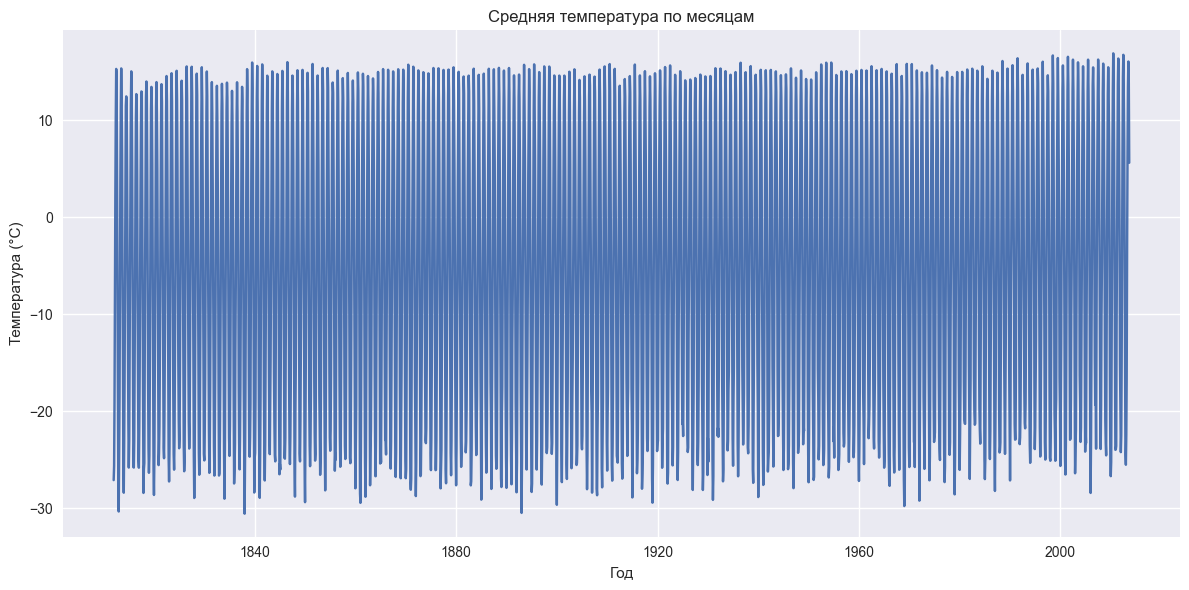


 Статистика температур:
• Средняя температура: -5.52°C
• Максимальная температура: 16.89°C
• Минимальная температура: -30.58°C
• Стандартное отклонение: 14.56°C
• Анализируемый период: 2421 месяцев


In [39]:

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['AverageTemperature'])
plt.title('Средняя температура по месяцам')
plt.xlabel('Год')
plt.ylabel('Температура (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()
# Дополнительная статистика
print(f"\n Статистика температур:")
print(f"• Средняя температура: {mean_temp:.2f}°C")
print(f"• Максимальная температура: {max_temp:.2f}°C")
print(f"• Минимальная температура: {min_temp:.2f}°C")
print(f"• Стандартное отклонение: {df['AverageTemperature'].std():.2f}°C")
print(f"• Анализируемый период: {len(df)} месяцев")

## Holdout-разбиение.

Корректное деление 80% train / 20% test по времени

In [41]:
# Количество строк 
n = len(df)

# Индекс точки разделения на трэйн и тест
split_idx = int(0.8 * n)

# Делим данные
train_data = df.iloc[:split_idx]
test_data = df.iloc[split_idx:]


In [42]:
print(f"Размер обучающей выборки: {len(train_data)}")
print(f"Размер тестовой выборки: {len(test_data)}")
print(f"Диапазон дат обучающей выборки: {train_data.index.min()} - {train_data.index.max()}")
print(f"Диапазон дат тестовой выборки: {test_data.index.min()} - {test_data.index.max()}")

Размер обучающей выборки: 1936
Размер тестовой выборки: 485
Диапазон дат обучающей выборки: 1812-01-01 00:00:00 - 1973-04-01 00:00:00
Диапазон дат тестовой выборки: 1973-05-01 00:00:00 - 2013-09-01 00:00:00


### Визуализация train/test на одном графике

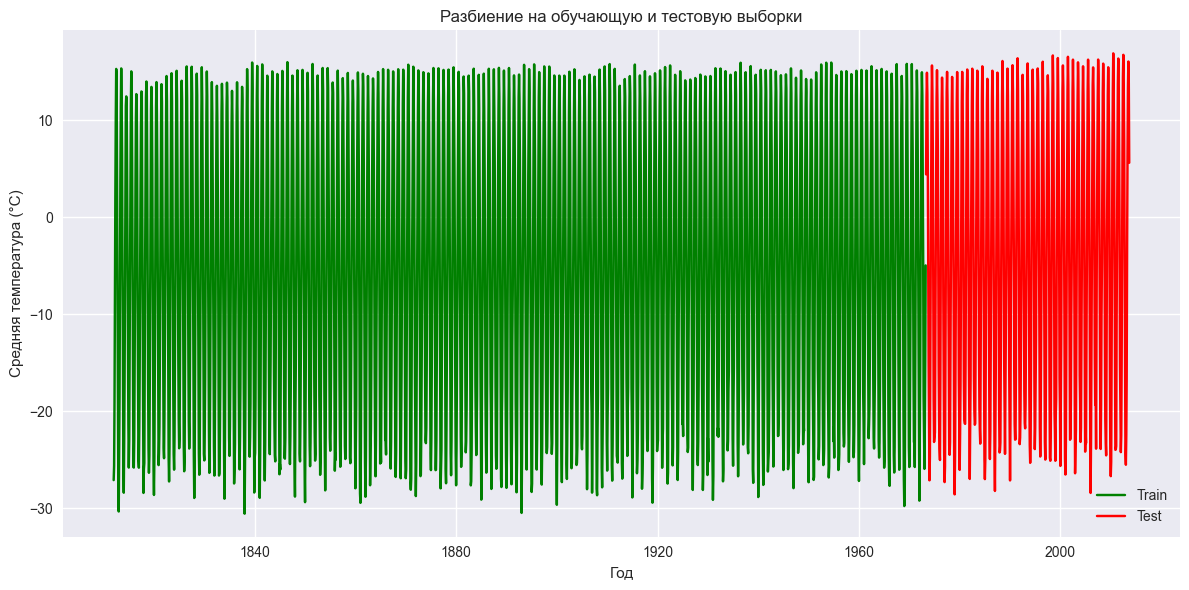

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['AverageTemperature'], label='Train', color='green')
plt.plot(test_data.index, test_data['AverageTemperature'], label='Test', color='red')
plt.title('Разбиение на обучающую и тестовую выборки')
plt.xlabel('Год')
plt.ylabel('Средняя температура (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Реализация скользящего окна (120 мес. обучение, 12 мес. прогноз)

In [46]:
train_window_size = 120
forecast_horizon = 12

dates = df.index
values = df['AverageTemperature'].values

# Найдем все возможные разбиения
splits = []
for start_idx in range(0, len(dates) - train_window_size - forecast_horizon + 1, forecast_horizon):
    
    train_idx_start = start_idx
    train_idx_end = start_idx + train_window_size
    test_idx_start = train_idx_end
    test_idx_end = test_idx_start + forecast_horizon
    
    
    train_split = (dates[train_idx_start:train_idx_end], values[train_idx_start:train_idx_end])
    test_split = (dates[test_idx_start:test_idx_end], values[test_idx_start:test_idx_end])
    
    splits.append((train_split, test_split))

print(f"Размер обучающего окна: {train_window_size} месяцев")
print(f"Прогнозный горизонт: {forecast_horizon} месяцев")
print(f"Количество скользящих разбиений: {len(splits)}")

Размер обучающего окна: 120 месяцев
Прогнозный горизонт: 12 месяцев
Количество скользящих разбиений: 191


### Визуализация хотя бы двух первых сплитов

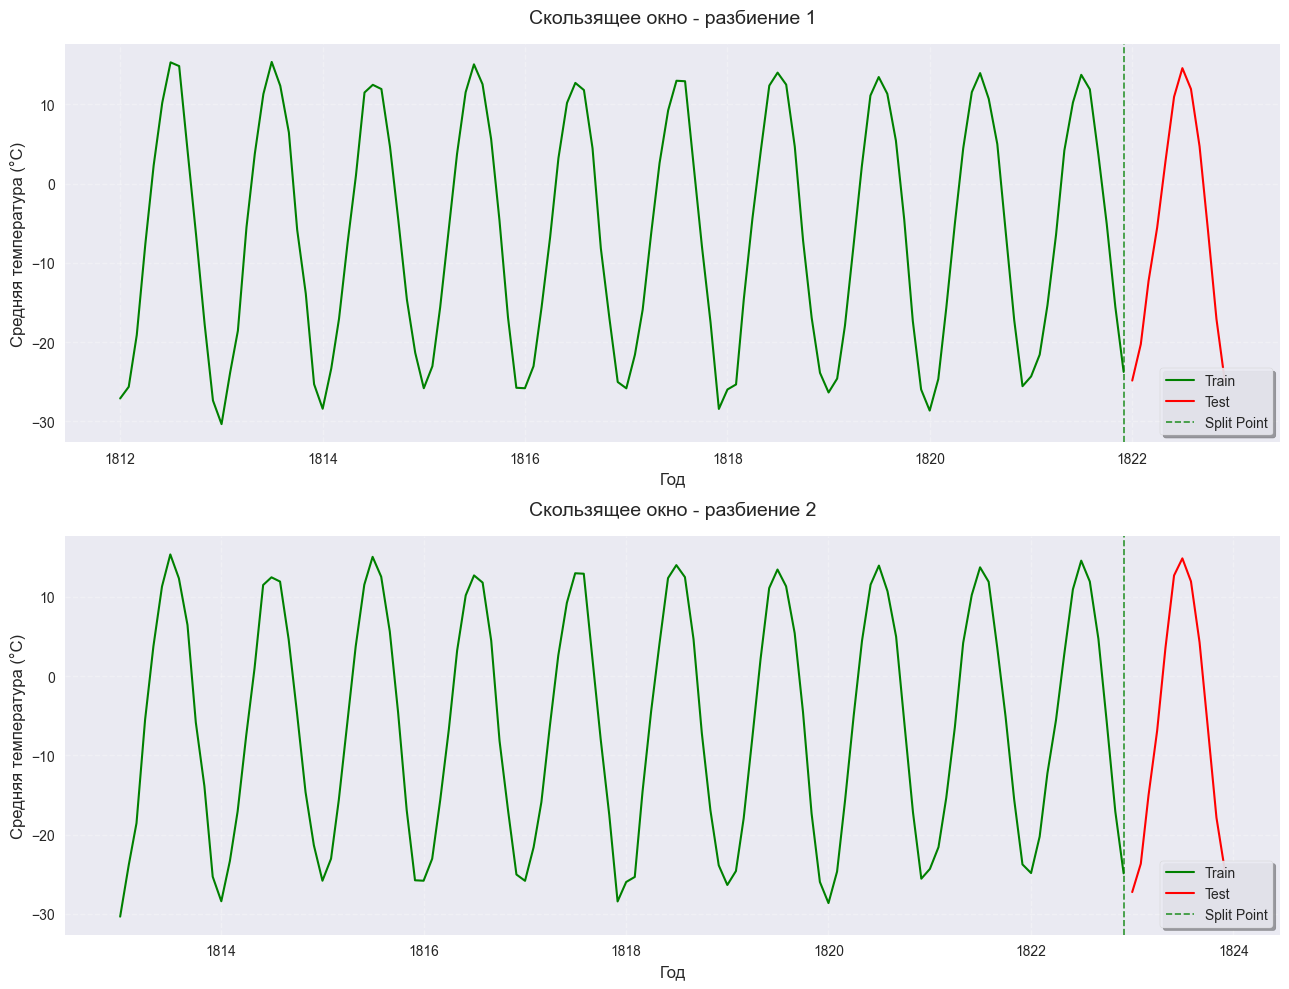

In [49]:
fig, axes = plt.subplots(2, 1, figsize=(13, 10))

for i in range(2):
    train_dates, train_vals = splits[i][0]
    test_dates, test_vals = splits[i][1]
    
    ax = axes[i]
    ax.plot(train_dates, train_vals, label='Train', color='green', linewidth=1.5)
    ax.plot(test_dates, test_vals, label='Test', color='red', linewidth=1.5)
    
   
    if len(train_dates) > 0:
        ax.axvline(x=train_dates[-1], color='green', linestyle='--', 
                   linewidth=1.2, alpha=0.8, label='Split Point')
    
    ax.set_title(f'Скользящее окно - разбиение {i+1}', fontsize=14, pad=15)
    ax.set_xlabel('Год', fontsize=12)
    ax.set_ylabel('Средняя температура (°C)', fontsize=12)
    ax.legend(frameon=True, fancybox=True, shadow=True, framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

### Генерация признаков.

#### Создание лагов (t-1, t-12)

In [51]:
train_data['lag_1'] = train_data['AverageTemperature'].shift(1)
train_data['lag_12'] = train_data['AverageTemperature'].shift(12)

test_data['lag_1'] = test_data['AverageTemperature'].shift(1)
test_data['lag_12'] = test_data['AverageTemperature'].shift(12)

#### Создание календарных признаков (номер месяца, индикатор зимы)

In [52]:
train_data['month'] = train_data.index.month
train_data['winter'] = train_data['month'].isin([12, 1, 2]).astype(int)

test_data['month'] = test_data.index.month
test_data['winter'] = test_data['month'].isin([12, 1, 2]).astype(int)

#### Вывод первых строк датафрейма с признаками

In [53]:
print(train_data.head())
print(test_data.head())

            AverageTemperature   lag_1  lag_12  month  winter
dt                                                           
1812-01-01             -27.114     NaN     NaN      1       1
1812-02-01             -25.644 -27.114     NaN      2       1
1812-03-01             -19.108 -25.644     NaN      3       0
1812-04-01              -7.605 -19.108     NaN      4       0
1812-05-01               2.296  -7.605     NaN      5       0
            AverageTemperature   lag_1  lag_12  month  winter
dt                                                           
1973-05-01               4.416     NaN     NaN      5       0
1973-06-01              12.347   4.416     NaN      6       0
1973-07-01              14.895  12.347     NaN      7       0
1973-08-01              12.736  14.895     NaN      8       0
1973-09-01               5.544  12.736     NaN      9       0


## Оценка прогноза.

Обучение простой модели (например, линейная регрессия)

In [56]:
# Подготовим данные
feature_cols = ['lag_1', 'lag_12', 'month', 'winter']
# Убираем пропуски 
train_data.dropna(inplace=True)

X = train_data[feature_cols]
y = train_data['AverageTemperature']

print(f"Размер признаков X: {X.shape}")
print(f"Размер целевой переменной y: {y.shape}")
print(f"Признаки: {feature_cols}")

# Обучаем модель линейной регрессии
model = LinearRegression()
model.fit(X, y)

print(f"Коэффициенты модели: {dict(zip(feature_cols, model.coef_))}")
print(f"Свободный член: {model.intercept_}")

Размер признаков X: (1924, 4)
Размер целевой переменной y: (1924,)
Признаки: ['lag_1', 'lag_12', 'month', 'winter']
Коэффициенты модели: {'lag_1': 0.09051267300152539, 'lag_12': 0.9076688607779745, 'month': -0.15735313555308886, 'winter': -0.6224110312192378}
Свободный член: 1.1776145421861246


#### Прогноз на тестовой выборке holdout

In [57]:
# Убираем пропуски 
test_data.dropna(inplace=True)

X_test = test_data[feature_cols]
y_test = test_data['AverageTemperature']

# Делаем предсказание
y_pred = model.predict(X_test)

### Метрики и интерпретация

#### Расчёт MAE, RMSE, MAPE

In [58]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"\nМетрики на тестовом наборе данных:")
print(f"MAE : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAPE : {mape:.4f}%")


Метрики на тестовом наборе данных:
MAE : 1.5673
RMSE : 2.1170
MAPE : 17.7082%


In [59]:
# Дополнительная интерпретация
print(f"\nДетальный анализ метрик:")
print(f"• Средняя абсолютная ошибка: {mae:.2f}°C")
print(f"• Максимальная типичная ошибка: {rmse:.2f}°C") 
print(f"• Относительная точность: {100-mape:.1f}%")

if mape < 10:
    print(" Отличная точность модели!")
elif mape < 20:
    print(" Хорошая точность модели")
elif mape < 30:
    print("  Умеренная точность, есть возможности для улучшения")
else:
    print(" Низкая точность, требуется доработка модели")


Детальный анализ метрик:
• Средняя абсолютная ошибка: 1.57°C
• Максимальная типичная ошибка: 2.12°C
• Относительная точность: 82.3%
 Хорошая точность модели


## Интерпретация результатов метрик:
### MAE (Mean Absolute Error) = 1.5673°C
Что означает: В среднем модель ошибается на 1.57°C в абсолютном значении

Интерпретация: Хороший результат, так как ошибка меньше 2°C обычно считается приемлемой для температурных прогнозов

### RMSE (Root Mean Square Error) = 2.1170°C
Что означает: Стандартное отклонение ошибок прогноза

Интерпретация: RMSE > MAE указывает на наличие отдельных значительных выбросов в ошибках

Разница с MAE: RMSE сильнее штрафует за большие ошибки

### MAPE (Mean Absolute Percentage Error) = 17.71%
Что означает: Средняя ошибка в процентах от фактических значений

Интерпретация:

17.71% - умеренная точность

Для температурных данных это приемлемый результат

Есть пространство для улучшения модели